# DCGAN Example with MNIST Dataset

In [1]:
import os
import tempfile

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.python.keras import layers

import fastestimator as fe
from fastestimator.op import TensorOp
from fastestimator.op.tensorop import Loss, ModelOp
from fastestimator.trace import ModelSaver

In [2]:
#parameters
batch_size = 256
epochs = 50
steps_per_epoch = None
validation_steps = None
saved_model_path = 'gen_epoch_45_step_10764.h5'

## Prepare data

We create `Pipeline` with MNIST data. With the help of `Myrescale` op, each image is normalized to between -1 and 1.

In [3]:
class Myrescale(TensorOp):
    """Scale image values from uint8 to float32 between -1 and 1."""
    def forward(self, data, state):
        data = tf.cast(data, tf.float32)
        data = (data - 127.5) / 127.5
        return data

In [4]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
data = {"train": {"x": np.expand_dims(x_train, -1)}}
pipeline = fe.Pipeline(batch_size=batch_size, data=data, ops=Myrescale(inputs="x", outputs="x"))

## Create network

### Keras models

First we create `tf.keras` models for generator and discriminator.

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

### FEModel

Next, we group the `tf.keras` models with `tf.optimizers` into `FEModel`.

In [7]:
g_femodel = fe.build(model_def=make_generator_model,
                    model_name="gen",
                    loss_name="gloss",
                    optimizer=tf.optimizers.Adam(1e-4))
d_femodel = fe.build(model_def=make_discriminator_model,
                    model_name="disc",
                    loss_name="dloss",
                    optimizer=tf.optimizers.Adam(1e-4))

The `FEModel` and `Loss` will be grouped into `Network`. Let's define the loss functions.

### Loss functions

We define the generator and discriminator loss. `Loss` can have multiple inputs and outputs.

In [8]:
class GLoss(Loss):
    """Compute generator loss."""
    def __init__(self, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                                reduction=tf.keras.losses.Reduction.NONE)

    def forward(self, data, state):
        return self.cross_entropy(tf.ones_like(data), data)

In [9]:
class DLoss(Loss):
    """Compute discriminator loss."""
    def __init__(self, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                                reduction=tf.keras.losses.Reduction.NONE)

    def forward(self, data, state):
        true, fake = data
        real_loss = self.cross_entropy(tf.ones_like(true), true)
        fake_loss = self.cross_entropy(tf.zeros_like(fake), fake)
        total_loss = real_loss + fake_loss
        return total_loss

### Network

Once loss functions are defined, we group `FEModel` and loss functions into `Network`.

In [10]:
network = fe.Network(ops=[
    ModelOp(inputs=lambda: tf.random.normal([batch_size, 100]), model=g_femodel),
    ModelOp(model=d_femodel, outputs="pred_fake"),
    ModelOp(inputs="x", model=d_femodel, outputs="pred_true"),
    GLoss(inputs=("pred_fake"), outputs="gloss"),
    DLoss(inputs=("pred_true", "pred_fake"), outputs="dloss")
])

## Create estimator

`Trace` is similar to callbacks in `tf.keras`. Here we use `ModelSaver` to save the training models to `save_dir`.

In [11]:
save_dir=tempfile.mkdtemp()

In [12]:
traces = [ModelSaver(model_name='gen', save_dir=save_dir, save_freq=5)]

Once everything is combined into `Estimator`, we can start traniing!

In [13]:
estimator = fe.Estimator(network=network, 
                         pipeline=pipeline, 
                         epochs=epochs, 
                         steps_per_epoch=steps_per_epoch, 
                         validation_steps=validation_steps,
                         traces=traces)

## Start Training

In [ ]:
estimator.fit()

## Generate images from random noise

We use the trained generator to generate images of digits.

In [ ]:
model = load_model(os.path.join(save_dir, saved_model_path))

In [19]:
images = model.predict(np.random.normal(size=(16, 100)))

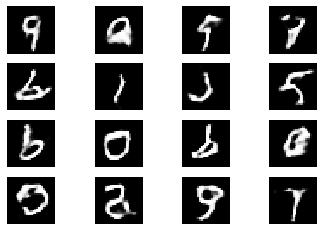

In [20]:
fig, axes = plt.subplots(4, 4)
axes = np.ravel(axes)
for i in range(images.shape[0]):
    axes[i].axis('off')
    axes[i].imshow(np.squeeze(images[i, ...] * 127.5 + 127.5), cmap='gray')